# Basic model analysis

January 17, 2023.

Experiments to analyse:
<ul>
    <li>EPM151, EPM152 - include tidal mixing</li>
    <li>EPM155, EPM156 - tidal mixing + Fox-Kemper</li>
    <li>EPM157, EPM158 - no tidal mixing, no Fox-Kemper control runs</li>
</ul>

Basic model analysis: 
<ul>
    <li>averaged over the Labrador Sea, as well as Labrador Sea interior (depth > 2000 m) and the Lab Sea convection region (can provide mask)</li>
    <li>top 50 m, top 200 m, top 1000 m and top 2000 m temperature and salinity</li>
    <li>top 50 m, top 200 m, top 1000 m and top 2000 m freshwater content (reference value 34.8)</li>
    <li>top 50 m, top 200 m, top 1000 m and top 2000 m heat content (reference value -1.8C - ice freezing point)</li>
    <li>top 50 m, top 200 m, top 1000 m and top 2000 m convective resistance</li>
    <li>top 50 m, top 200 m, top 1000 m and top 2000 m EKE</li>
    <li>average MLD </li>
    <li>maximum MLD</li>
</ul>

2D surface plots:
<ul>
    <li>sea surface height</li>
    <li>top 50 m, top 200 m, top 1000 m and top 2000 m temperature, salinity, FWC and heat content</li>
    <li>top 50 m, top 200 m, top 1000 m and top 2000 m convective resistance</li>
    <li>top 50 m, top 200 m, top 1000 m and top 2000 m EKE</li>
    <li>top 50 m current velocity</li>
    <li>average winter MLD</li>
    <li>maximum winter MLD</li>
</ul>
We'll need to use the timeseries in part I to decide the time periods to average over.

Cross-sections:
<ul>
    <li>AR7W and OSNAP-west sections</li>
    <li>Temperature, salinity, Cross-sectional velocity</li>
</ul>
Again, the timeseries in part I will help decide the averaging periods.

Transports:
<ul>
    <li>Volume, heat and freshwater</li>
    <li>Across 2000 m isobath from basin to shelf (or vice versa)</li>
</ul>

Imports:

In [3]:
import numpy as np 
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
#import datetime as dt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as feature
import os

List of filepaths (could be a nicer loop...):

In [4]:
#ordered filepaths function
def filePaths_Function(outputFolder: str,suffix: str):
    """ Return chrono. list of filepaths with specified outout/model \
        run and suffix (e.g. 'gridT.nc' or 'gridU.nc')"""
    return sorted([outputFolder + file for file in os.listdir(outputFolder) if \
        file.endswith(suffix)])

#complete list of filepaths
gridT151 = filePaths_Function('/mnt/storage6/myers/NEMO/ANHA4-EPM151/','gridT.nc')
gridU151 = filePaths_Function('/mnt/storage6/myers/NEMO/ANHA4-EPM151/','gridU.nc')
gridV151 = filePaths_Function('/mnt/storage6/myers/NEMO/ANHA4-EPM151/','gridV.nc')
gridT152 = filePaths_Function('/mnt/storage6/myers/NEMO/ANHA4-EPM152/','gridT.nc')
gridU152 = filePaths_Function('/mnt/storage6/myers/NEMO/ANHA4-EPM152/','gridU.nc')
gridV152 = filePaths_Function('/mnt/storage6/myers/NEMO/ANHA4-EPM152/','gridV.nc')

#shortening list for efficiency
paths_gridT151 = gridT151[0::600] 
paths_gridU151 = gridU151[0::600] 
paths_gridV151 = gridV151[0::600] 
paths_gridT152 = gridT152[0::600] 
paths_gridU152 = gridU152[0::600] 
paths_gridV152 = gridV152[0::600] 

Assorted inputs:

In [5]:
#levels to average until
depths = [50, 200, 1000, 2000] 

#reference values
refS = 34.8 #PSU
refT = -1.8 #C

#density (const. value?)
rho = 1025 #kg/m^3

#specific heat capacity (const. value?)
c_p = 3850 #J/kgK

#horizontal mask
hz_mask = '/mnt/storage6/clark/NEMO_meshes/ANHA4/50VerticalLevels/ARGOProfiles_mask.nc'
with xr.open_dataset(hz_mask) as DS:
    LS_convec_mask = DS.tmask.fillna(0).to_numpy()

Getting average temperatures, salinity in the surface waters, at different depths and within a mask (check that salinity is on same grid as temperature, also check if your heat content algorithm is right):

In [4]:
#gridT horizontal cell dims
grid = '/mnt/storage4/tahya/model_files/ANHA4_mesh_mask.nc'
with xr.open_dataset(grid) as DS:
    e1t = DS.e1t[0,:,:].rename({'y': 'y_grid_T','x': 'x_grid_T'}) #renames dims
    e2t = DS.e2t[0,:,:].rename({'y': 'y_grid_T','x': 'x_grid_T'})
    lons = np.array(DS.variables['nav_lon'])
    lats = np.array(DS.variables['nav_lat'])

preprocess_gridT = lambda ds: ds[['e3t','votemper','vosaline','somxl010']] #desired variables
DS = xr.open_mfdataset(paths_gridT151,preprocess=preprocess_gridT) #opens dataset
DS[['e1t','e2t']] = e1t,e2t #adds T cell dims as variables
DS.coords['LS_convec_mask'] = (('y_grid_T', 'x_grid_T'), LS_convec_mask) #adds mask as coords
DS = DS.where(DS.LS_convec_mask == 1, drop=True) #drops data out of mask
DS['adjusted_votemper'] = DS.votemper + refT

for d in depths: #loops through depths

    DS_d = DS.where(DS.deptht < d, drop=True) #drops values below specified depth
    DS_d['volT'] = DS_d.e1t*DS_d.e3t*DS_d.e2t #volumes of T cells
    DS_d['volT_total'] = DS_d.volT.sum(dim=['x_grid_T','y_grid_T','deptht']) #volume of region

    DS_d['votemper_weighted'] = DS_d.volT*DS_d.votemper #weighted temps
    avgT = DS_d.votemper_weighted.sum(dim=['x_grid_T','y_grid_T','deptht'])\
        /DS_d.volT.sum(dim=['x_grid_T','y_grid_T','deptht']) #average temperature
    DS['avgT'+str(d)] = avgT

    DS_d['adjusted_votemper_weighted'] = DS_d.volT*DS_d.adjusted_votemper #weighted temps
    adjusted_avgT = DS_d.adjusted_votemper_weighted.sum(dim=['x_grid_T','y_grid_T','deptht'])\
        /DS_d.volT_total #average adjusted temperature
    DS['heat'+str(d)] = adjusted_avgT * c_p * (DS_d.volT_total*rho) * 10**(-12) #TJ
    
    DS_d['vosaline_weighted'] = DS_d.volT*DS_d.vosaline #weighted salinities
    avgS = DS_d.vosaline_weighted.sum(dim=['x_grid_T','y_grid_T','deptht'])\
        /DS_d.volT.sum(dim=['x_grid_T','y_grid_T','deptht']) #average salinities
    DS['avgS'+str(d)] = avgS

    DS['FW'+str(d)] = DS_d.volT_total - avgS*DS_d.volT_total/refS #FW volume
    DS['volT_total'+str(d)] = DS_d.volT_total

Plotting temperature:

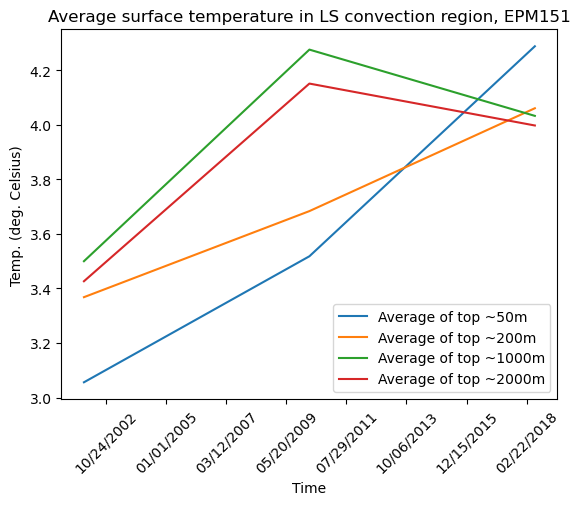

In [ ]:
dates = DS.indexes['time_counter'].to_datetimeindex(unsafe=True) #Beware: warning turned off!!
dates = [d.date() for d in dates]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=800)) # Use interval of a year
plt.plot(dates, DS.avgT50, label = "Average of top ~50m") #or, around 50m...
plt.plot(dates, DS.avgT200, label = "Average of top ~200m")
plt.plot(dates, DS.avgT1000, label = "Average of top ~1000m")
plt.plot(dates, DS.avgT2000, label = "Average of top ~2000m")
plt.legend()
plt.xticks(rotation=45)
plt.title('Average surface temperature in LS convection region, EPM151')
plt.ylabel('Temp. (deg. Celsius)')
plt.xlabel('Time')
plt.savefig('temp-EPM151_Temperature_convectiveRegion.png', bbox_inches="tight")

Plotting salinity:

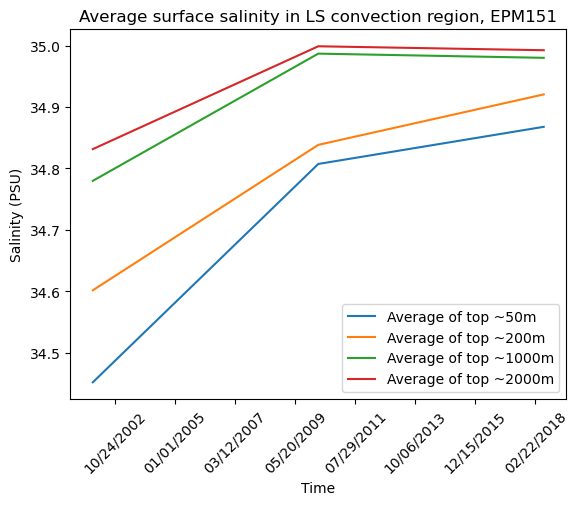

In [ ]:
dates = DS.indexes['time_counter'].to_datetimeindex(unsafe=True) #Beware: warning turned off!!
dates = [d.date() for d in dates]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=800)) # Use interval of a year
plt.plot(dates, DS.avgS50, label = "Average of top ~50m") #or, around 50m...
plt.plot(dates, DS.avgS200, label = "Average of top ~200m")
plt.plot(dates, DS.avgS1000, label = "Average of top ~1000m")
plt.plot(dates, DS.avgS2000, label = "Average of top ~2000m")
plt.legend()
plt.xticks(rotation=45)
plt.title('Average surface salinity in LS convection region, EPM151')
plt.ylabel('Salinity (PSU)')
plt.xlabel('Time')
plt.savefig('temp-EPM151_Salinity_convectiveRegion.png', bbox_inches="tight")

Plotting FW content:

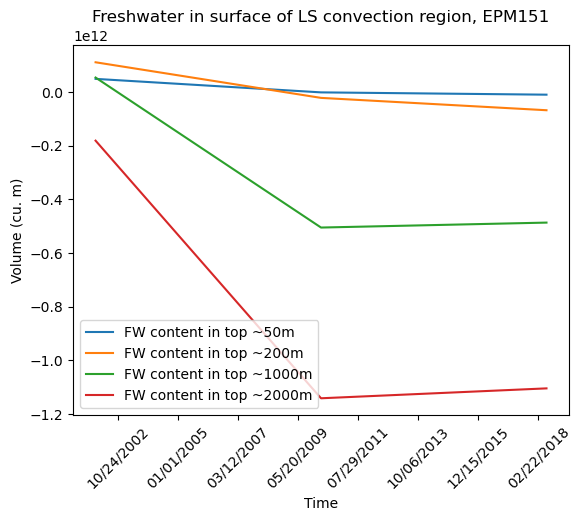

In [ ]:
dates = DS.indexes['time_counter'].to_datetimeindex(unsafe=True) #Beware: warning turned off!!
dates = [d.date() for d in dates]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=800)) # Use interval of a year
plt.plot(dates, DS.FW50, label = "FW content in top ~50m") #normalize along depth
plt.plot(dates, DS.FW200, label = "FW content in top ~200m")
plt.plot(dates, DS.FW1000, label = "FW content in top ~1000m")
plt.plot(dates, DS.FW2000, label = "FW content in top ~2000m")
plt.legend()
plt.xticks(rotation=45)
plt.title('Freshwater in surface of LS convection region, EPM151')
plt.ylabel('Volume (cu. m)') #are there too many decimals? (Convert to cu. km)
plt.xlabel('Time')
plt.savefig('temp-EPM151_FW_convectiveRegion.png', bbox_inches="tight")

Plotting heat content (check that this is right!!! Units: J or W???):

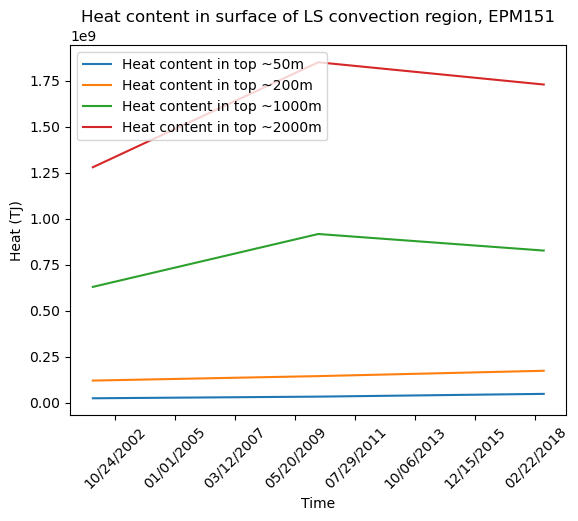

In [ ]:
dates = DS.indexes['time_counter'].to_datetimeindex(unsafe=True) #Beware: warning turned off!!
dates = [d.date() for d in dates]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=800)) # Use interval of a year
plt.plot(dates, DS.heat50, label = "Heat content in top ~50m") #normalize along depth
plt.plot(dates, DS.heat200, label = "Heat content in top ~200m")
plt.plot(dates, DS.heat1000, label = "Heat content in top ~1000m")
plt.plot(dates, DS.heat2000, label = "Heat content in top ~2000m")
plt.legend()
plt.xticks(rotation=45)
plt.title('Heat content in surface of LS convection region, EPM151')
plt.ylabel('Heat (TJ)') #are there too many decimals?
plt.xlabel('Time')
plt.savefig('temp-EPM151_heat_convectiveRegion.png', bbox_inches="tight")

Getting EKE in the surface waters, at different depths and within a mask:

In [ ]:
#horizontal cell dims
with xr.open_dataset('ANHA4_mesh_mask.nc') as DS:
    e1u = DS.e1u[0,:,:].rename({'y': 'y_grid_T','x': 'x_grid_T'})
    e2u = DS.e2u[0,:,:].rename({'y': 'y_grid_T','x': 'x_grid_T'})
    e1v = DS.e1v[0,:,:].rename({'y': 'y_grid_T','x': 'x_grid_T'})
    e2v = DS.e2v[0,:,:].rename({'y': 'y_grid_T','x': 'x_grid_T'})

preprocess_gridU = lambda ds: ds[['e3u','vozocrtx']] #desired variables
DSU = xr.open_mfdataset(paths_gridU151,preprocess=preprocess_gridU) #opens dataset

preprocess_gridV = lambda ds: ds[['e3v','vomecrty']] #desired variables
DSV = xr.open_mfdataset(paths_gridV151,preprocess=preprocess_gridV) #opens dataset

##########Jan 25, 2023###########



display(DSV.nav_lat[356,190].to_numpy())
display(DSU.nav_lat[356,190].to_numpy())

#NOTE: THEY AREN'T IN THE SAME LOCATION --- YOU'LL HAVE TO LINEAR INTERP



#C+P from above

DS[['e1t','e2t']] = e1t,e2t #adds T cell dims as variables
DS.coords['LS_convec_mask'] = (('y_grid_T', 'x_grid_T'), LS_convec_mask) #adds mask as coords
DS = DS.where(DS.LS_convec_mask == 1, drop=True) #drops data out of mask

for d in depths: #loops through depths

    DS_d = DS.where(DS.deptht < d, drop=True) #drops values below specified depth
    DS_d['volT'] = DS_d.e1t*DS_d.e3t*DS_d.e2t #volumes of T cells
    DS_d['volT_total'] = DS_d.volT.sum(dim=['x_grid_T','y_grid_T','deptht']) #volume of region

    DS_d['votemper_weighted'] = DS_d.volT*DS_d.votemper #weighted temps
    avgT = DS_d.votemper_weighted.sum(dim=['x_grid_T','y_grid_T','deptht'])\
        /DS_d.volT.sum(dim=['x_grid_T','y_grid_T','deptht']) #average temperature
    DS['avgT'+str(d)] = avgT
    
    DS_d['vosaline_weighted'] = DS_d.volT*DS_d.vosaline #weighted salinities
    avgS = DS_d.vosaline_weighted.sum(dim=['x_grid_T','y_grid_T','deptht'])\
        /DS_d.volT.sum(dim=['x_grid_T','y_grid_T','deptht']) #average salinities
    DS['avgS'+str(d)] = avgS

    DS['FW'+str(d)] = DS_d.volT_total - avgS*DS_d.volT_total/refS #FW volume
    DS['volT_total'+str(d)] = DS_d.volT_total

Mesh mask:

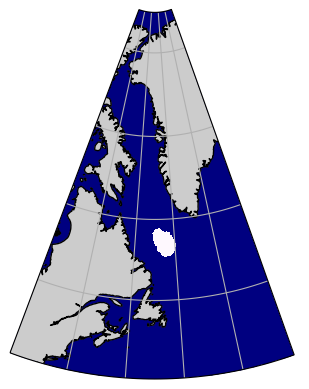

In [47]:

mask_path = '/mnt/storage6/clark/NEMO_meshes/ANHA4/50VerticalLevels/ARGOProfiles_mask.nc'
grid_path = '/mnt/storage4/tahya/model_files/ANHA4_mesh_mask.nc'

with xr.open_dataset(mask_path) as DS:
    mask = DS.tmask.fillna(0).to_numpy()

with xr.open_dataset(grid_path) as DS:
    lons = np.array(DS.variables['nav_lon'])
    lats = np.array(DS.variables['nav_lat'])

land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',edgecolor='black', facecolor='gray', linewidth=0.5)
projection=ccrs.AlbersEqualArea(central_longitude=-55, central_latitude=50,standard_parallels=(40,85))
#fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([-80, -30, 40, 85], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

vertices = [(lon, 40) for lon in range(-80, -30, 1)] + [(lon, 85) for lon in range(-30, -80, -1)]
boundary = mpath.Path(vertices)
ax.set_boundary(boundary, transform=ccrs.PlateCarree())

#ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
p1 = ax.pcolormesh(lons, lats, mask, transform=ccrs.PlateCarree(), cmap='gist_ncar')#, vmin=0, vmax=5)
#cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')#
#cb.ax.set_ylabel('Test')
ax.gridlines()
plt.savefig('temp-mask.png')


Sea surface height:

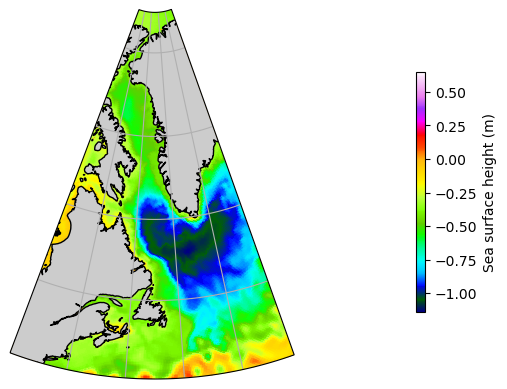

In [49]:
with xr.open_dataset(grid) as DS:
    lons = np.array(DS.variables['nav_lon'])
    lats = np.array(DS.variables['nav_lat'])

file = '/mnt/storage6/myers/NEMO/ANHA4-EPM151/ANHA4-EPM151_y2021m12d26_gridT.nc'
with xr.open_dataset(file) as DS:
    ssh = DS.sossheig[0,:,:]

land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',edgecolor='black', facecolor='gray', linewidth=0.5)
projection=ccrs.AlbersEqualArea(central_longitude=-55, central_latitude=50,standard_parallels=(40,85))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([-80, -30, 40, 85], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

vertices = [(lon, 40) for lon in range(-80, -30, 1)] + [(lon, 85) for lon in range(-30, -80, -1)]
boundary = mpath.Path(vertices)
ax.set_boundary(boundary, transform=ccrs.PlateCarree())

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
p1 = ax.pcolormesh(lons, lats, ssh, transform=ccrs.PlateCarree(), cmap='gist_ncar')#, vmin=0, vmax=5)
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')#
cb.ax.set_ylabel('Sea surface height (m)')
ax.gridlines()
plt.savefig('temp-mask.png')